# Find Asteroids

In this notebook we present a procedure to detect moving objects (asteroid or in general small bodies) in a set of images taken at different epochs.

The idea is to detect a moving object in a set of images like this:

![alt text][asteroid]
[asteroid]: images/asteroid.gif

For performing this task we use different tools:

- [SEXtractor](https://www.astromatic.net/software/sextractor), for extracting the sources
- [Astrometry.net](http://astrometry.net/doc/readme.html), for performing astrometry on the image and find the reference stars.



## Required modules

The following modules are required

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
import glob
from collections import OrderedDict
import collections
import pandas as pd
from os import system
import warnings
warnings.filterwarnings('ignore')

%matplotlib nbagg

**NOTE**: You must run the last cell before continue

## Locations

Determine where the required information and executables are located

In [182]:
DATA_DIR="data/"
SETS_DIR=DATA_DIR+"sets/"
REP_DIR=DATA_DIR+"reports/"
IMAGE_DIR="images/"
SCR_DIR="scratch/"
INPUT_DIR="input/"
AST_DIR="/home/astrometry/astrometry/"
SEX_DIR="/home/astrometry/sextractor/"

## Set of images & Configuration

In [27]:
SET="ps1-20170914_4_set096"
CFG=SET.split("-")[0]+".cfg"
cfg=[line.rstrip('\n') for line in open(SETS_DIR+CFG)]
#cfg

Image analysed by humans:
![alt text][report]
[report]: images/example-report.jpg

## Unpack images

In [28]:
OUT_DIR=SCR_DIR+SET+"/"
out=System("mkdir -p "+OUT_DIR)
out=System("cp "+INPUT_DIR+"template/* "+OUT_DIR)
out=System("unzip -o -d "+OUT_DIR+" "+SETS_DIR+SET+".zip")

Archive:  data/sets/ps1-20170914_4_set096.zip
  inflating: scratch/ps1-20170914_4_set096/o8010g0344o.1300829.ch.1992525.XY36.p00.fits
  inflating: scratch/ps1-20170914_4_set096/o8010g0362o.1300847.ch.1992543.XY36.p00.fits
  inflating: scratch/ps1-20170914_4_set096/o8010g0380o.1300865.ch.1992561.XY36.p00.fits
  inflating: scratch/ps1-20170914_4_set096/o8010g0398o.1300883.ch.1992579.XY36.p00.fits


## Read images

In [413]:
images=[]
for image in sorted(glob.glob(OUT_DIR+"*.fits")):
    print("Reading image "+image)
    hdul=fits.open(image)
    im=dict()
    im["file"]=image.split("/")[-1].replace(".fits","")
    im["header"]=hdul[0].header
    im["data"]=hdul[0].data
    im["obstime"]=hdul[0].header["DATE-OBS"]
    images+=[im]
    hdul.close()

Reading image scratch/ps1-20170914_4_set096/o8010g0344o.1300829.ch.1992525.XY36.p00.fits
Reading image scratch/ps1-20170914_4_set096/o8010g0362o.1300847.ch.1992543.XY36.p00.fits
Reading image scratch/ps1-20170914_4_set096/o8010g0380o.1300865.ch.1992561.XY36.p00.fits
Reading image scratch/ps1-20170914_4_set096/o8010g0398o.1300883.ch.1992579.XY36.p00.fits


In [414]:
#Uncomment to check image headers
#images[0]["header"]
images[2]["obstime"]

'2017-09-14T10:29:12.752865'

## Properties of image

In [415]:
#Angular size of each pixel
pxdx=np.arctan(pxx/F)*RAD

F=Config(cfg,"FocalLength") #Microns
pxx=Config(cfg,"PixelWide") #Microns
pxdx=np.arctan(pxx/F)*RAD
sizex=images[0]["header"]["NAXIS1"]
pxy=Config(cfg,"PixelHigh") #Microns
sizey=images[0]["header"]["NAXIS2"]
pxdy=np.arctan(pxy/F)*RAD

print("Pixel size (micras): %f x %f"%(pxx,pxy))
print("Pixel size (arcsec): %f x %f"%(pxdx/ARCSEC,pxdy/ARCSEC))
print("CCD Field (deg): %f x %f"%(sizex*pxdx,sizey*pxdy))

pxsize=(pxdx+pxdy)/2

print("Average pixel size (arcsec):",pxsize/ARCSEC)

Pixel size (micras): 0.010000 x 0.010000
Pixel size (arcsec): 0.255595 x 0.255595
CCD Field (deg): 0.172029 x 0.172810
Average pixel size (arcsec): 0.255594555449


### Show images

<IPython.core.display.Javascript object>


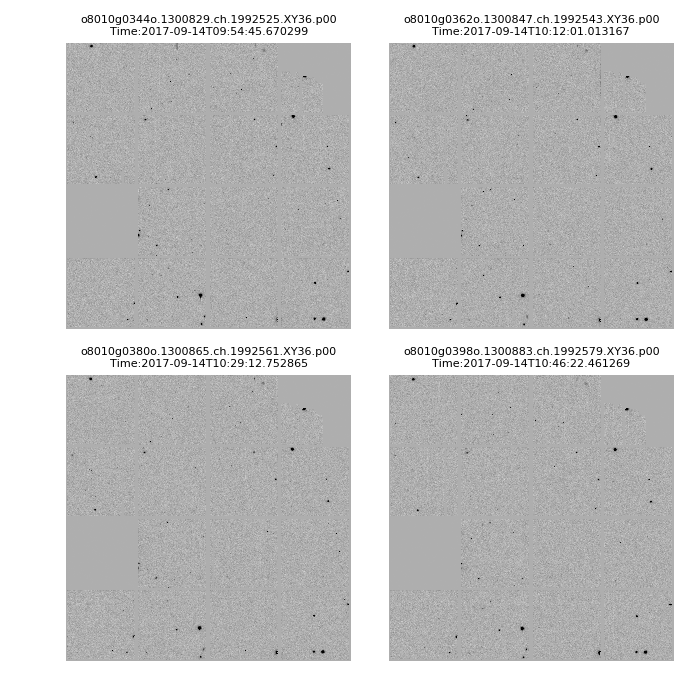

In [606]:
fig,axs=plt.subplots(2,2,sharex=True,sharey=True,figsize=(7,7))
imgargs=dict(cmap='gray_r',vmin=0,vmax=500)
i=0
for lax in axs:
    for ax in lax:  
        ax.imshow(images[i]["data"],**imgargs)
        images[i]["ax"]=ax
        i+=1
        
for i,ax in enumerate(mat2lst(axs)):
    ax.axis("off")
    time=images[i]["header"]["DATE-OBS"]
    ax.set_title(images[i]["file"]+"\n"+"Time:"+time,fontsize=8,position=(0.5,1.0))
    #ax.set_title("Image %d"%i,fontsize=8)
fig.tight_layout()

## Run Astrometry.net

In [417]:
for image in images:
    file=image["file"]
    header=image["header"]

    #GET COORDINATES
    ra=sex2dec(header["OBJCTRA"])*15
    dec=sex2dec(header["OBJCTDEC"])

    #ASTROMETRY.NET COMMAND
    print("Running astrometry over %s..."%file)
    opts=""
    opts+=" "+"--use-sextractor --sextractor-path "+SEX_DIR+"bin/sex"
    opts+=" "+"--no-plots"
    opts+=" "+"--ra %.7f --dec %.7f --radius 1"%(ra,dec)
    opts+=" "+"--guess-scale --overwrite"
    cmd=AST_DIR+"bin/solve-field "+opts+" "+file+".fits"
    sys="cd "+OUT_DIR+";"+cmd
    out=System(sys,False)
    if out[-1][0]!=0:
        print("Error processing image")
        print(out[-1][1])
    else:
        print("\tAstrometry processing successful")
        #STORE RESULTS
        image["astro_output"]="\n".join(out[:-1])

        #SOURCE XY AND MAG
        hdul=fits.open(OUT_DIR+"%s.axy"%file)
        image["objects_header"]=hdul[1].header
        image["objects"]=hdul[1].data
        hdul.close()

        #SOURCES RA,DEC
        cmd=AST_DIR+"bin/wcs-xy2rd -X 'X_IMAGE' -Y 'Y_IMAGE' -w %s.wcs -i %s.axy -o %s.ard"%(file,file,file)
        sys="cd "+OUT_DIR+";"+cmd
        out=System(sys,False)

        hdul=fits.open(OUT_DIR+"%s.ard"%file)
        image["objectsrd_header"]=hdul[1].header
        image["objectsrd"]=hdul[1].data
        hdul.close()
        
        #STARS X,Y
        hdul=fits.open(OUT_DIR+"%s-indx.xyls"%file)
        image["stars_header"]=hdul[1].header
        image["stars"]=hdul[1].data
        hdul.close()
    
        #STARS RA,DEC
        hdul=fits.open(OUT_DIR+"%s.rdls"%file)
        image["sources_header"]=hdul[1].header
        image["sources"]=hdul[1].data
        hdul.close()

    #break
print("Done.")

Running astrometry over o8010g0344o.1300829.ch.1992525.XY36.p00...
	Astrometry processing successful
Running astrometry over o8010g0362o.1300847.ch.1992543.XY36.p00...
	Astrometry processing successful
Running astrometry over o8010g0380o.1300865.ch.1992561.XY36.p00...
	Astrometry processing successful
Running astrometry over o8010g0398o.1300883.ch.1992579.XY36.p00...
	Astrometry processing successful
Done.


In [418]:
#Uncomment to see objects attributes
#images[0]["objects_header"]
#images[0]["stars_header"]

## Running SEXtractor

In [419]:
for image in images:
    file=image["file"]
    header=image["header"]

    #SEX COMMAND
    print("Running SEXtractor over %s..."%file)
    opts=""
    opts+=" "+"-c asteroid.sex"
    cmd=SEX_DIR+"bin/sex "+opts+" "+file+".fits"
    sys="cd "+OUT_DIR+";"+cmd
    out=System(sys)
    if out[-1][0]!=0:
        print("Error processing image")
        print(out[-1][1])
    else:
        print("\tExtraction successful")
        #STORE RESULTS
        image["sex_output"]=out[-1][1]
        System("cd "+OUT_DIR+";cp asteroid.cat %s.cat"%file,False)
        hdul=fits.open(OUT_DIR+"%s.cat"%file)
        image["catalogue_header"]=hdul[1].header
        image["catalogue"]=hdul[1].data
        hdul.close()
    #break
print("Done.")

Running SEXtractor over o8010g0344o.1300829.ch.1992525.XY36.p00...
	Extraction successful
Running SEXtractor over o8010g0362o.1300847.ch.1992543.XY36.p00...
	Extraction successful
Running SEXtractor over o8010g0380o.1300865.ch.1992561.XY36.p00...
	Extraction successful
Running SEXtractor over o8010g0398o.1300883.ch.1992579.XY36.p00...
	Extraction successful
Done.


In [420]:
#Uncomment to see catalogue stars
#images[0]["catalogue_header"]

## Showing objecs

In [320]:
for image in images:
    objects=image["objects"]
    stars=image["stars"]
    catalogue=image["catalogue"]
    ax=image["ax"]
    ax.plot(objects["X_IMAGE"],objects["Y_IMAGE"],'ro',ms=5,mfc='None')
    ax.plot(stars["X"],stars["Y"],'gs',ms=10,mfc='None')
    ax.plot(catalogue["X_IMAGE"],catalogue["Y_IMAGE"],'bv',ms=10,mfc='None')
    for i in range(len(catalogue)):
        text=str(catalogue["MAG_BEST"][i])
        text="Src.%d"%i
        ax.text(catalogue["X_IMAGE"][i],catalogue["Y_IMAGE"][i],text,
                color='w',zorder=100,fontsize=6,rotation=45,ha='left',va='bottom')
        break
    #break

## Analysing a single object

In [43]:
#Coordinates
image=images[0]
#iobj=60 #Astrometrica. SNR = 7.67 
#iobj=311 #Asteroid
iobj=201 #Close star, SNR =16.7 (brightest star)
#iobj=217 #Close star, SNR =16.7
#iobj=221 #Close star, SNR = 5.0
#iobj=299 #Close star, SNR = 4.5
x=int(image["catalogue"]["X_IMAGE"][iobj])
y=int(image["catalogue"]["Y_IMAGE"][iobj])
dx=int(np.ceil(np.sqrt(image["catalogue"]["X2_IMAGE"][iobj])))
dy=int(np.ceil(np.sqrt(image["catalogue"]["Y2_IMAGE"][iobj])))

mag=image["catalogue"]["MAG_BEST"][iobj]
ra=image["objectsrd"]["RA"][iobj]/15
dec=image["objectsrd"]["DEC"][iobj]
print("RA = (%.7f) "%ra,dec2sex(ra))
print("DEC = (%.7f) "%dec,dec2sex(dec))
print("mag = ",mag)

RA = (23.6473897)  (23.0, 38, 50.603051549586269)
DEC = (-4.1402778)  (-4.0, 8, 25.000128272169491)
mag =  -11.4755


In [44]:
#Plot on image
ax=image["ax"]
ax.plot(x,y,'wo',ms=5,mfc='None')

### Fitting in 1D

In [45]:
#Fitting over a line
#http://docs.astropy.org/en/stable/modeling/index.html
data=rec2arr(image["data"])
ws=5
xs=np.arange(x-ws*dx,x+ws*dx,1)
pxs=data[y,x-ws*dx:x+ws*dx,0]
ys=np.arange(y-ws*dy,y+ws*dy,1)
pys=data[y-ws*dy:y+ws*dy,x,0]

#Fit x
mean=x
sigma2=dx**2
xf=xs
yf=pxs

def gaussianLevel(t,level=0.0,amplitude=1.0,mean=mean,sigma2=sigma2):
    g=amplitude*np.exp(-0.5*((t-mean)**2/sigma2))
    f=g+level
    return f

g_init=custom_model(gaussianLevel)()
#fit=fitting.LevMarLSQFitter()
fit=fitting.SLSQPLSQFitter()
gx=fit(g_init,xf,yf,verblevel=0)
rs=gx(xs)-pxs
noise=rs.std()
SNRx=gx.amplitude.value/noise
print("SNR(x)=",SNRx)

#Fit y
mean=y
sigma2=dy**2
xf=ys
yf=pys

def gaussianLevel(t,level=0.0,amplitude=1.0,mean=mean,sigma2=sigma2):
    g=amplitude*np.exp(-0.5*((t-mean)**2/sigma2))
    f=g+level
    return f

g_init=custom_model(gaussianLevel)()
#fit=fitting.LevMarLSQFitter()
fit=fitting.SLSQPLSQFitter()
gy=fit(g_init,xf,yf,verblevel=0)
rs=gy(ys)-pys
noise=rs.std()

SNRy=gy.amplitude.value/noise
#SNRy=gy.amplitude.value/np.sqrt(gy.amplitude.value+gy.level.value)
#SNRy=gy.amplitude.value/np.sqrt(gy.level.value**2+5.171346**2)
print("SNR(y)=",SNRy)
print(gx)
print(gy)

SNR(x)= 19.094391021
SNR(y)= 21.3225161971
Model: gaussianLevel
Inputs: ('t',)
Outputs: ('t',)
Model set size: 1
Parameters:
       level       amplitude        mean        sigma2   
    ------------ ------------- ------------- ------------
    173.88764183 585.969342354 868.486004173 6.1262849979
Model: gaussianLevel
Inputs: ('t',)
Outputs: ('t',)
Model set size: 1
Parameters:
        level       amplitude        mean         sigma2   
    ------------- ------------- ------------- -------------
    188.083105533 544.236501773 1245.92642102 5.57017843203


### Plot 1D fit 

<IPython.core.display.Javascript object>


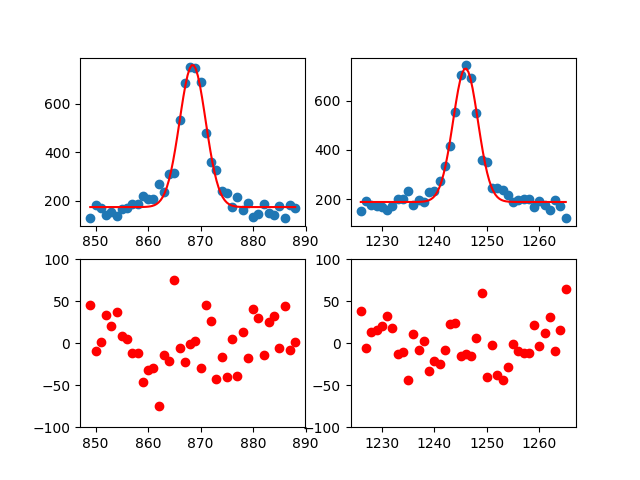

(-100, 100)

In [46]:
fig,axs=plt.subplots(2,2)

axf=axs[0][0]
axf.plot(xs,pxs,'o')
xss=np.linspace(xs[0],xs[-1],100)
axf.plot(xss,gx(xss),'r-')

axf=axs[1][0]
rs=gx(xs)-pxs
axf.plot(xs,rs,'ro')
axf.set_ylim(-100,100)

axf=axs[0][1]
axf.plot(ys,pys,'o')
yss=np.linspace(ys[0],ys[-1],100)
axf.plot(yss,gy(yss),'r-')

axf=axs[1][1]
rs=gy(ys)-pys
axf.plot(ys,rs,'ro')
axf.set_ylim(-100,100)

### Fitting in 2D

In [47]:
#Fitting over the whole PSF
sigmax2=dx**2
sigmay2=dy**2
meanx=x
meany=y
X,Y=np.meshgrid(xs,ys)
P=data[y-ws*dy:y+ws*dy,x-ws*dx:x+ws*dx,0]

def gaussianLevel2(tx,ty,level=0.0,amplitude=1.0,
                   meanx=meanx,meany=meany,
                   sigmax2=sigmax2,sigmay2=sigmay2):
    g=amplitude*np.exp(-0.5*((tx-meanx)**2/sigmax2+(ty-meany)**2/sigmay2))
    f=g+level
    return f

g_init=custom_model(gaussianLevel2)()
fit=fitting.SLSQPLSQFitter()
g=fit(g_init,X,Y,P,verblevel=1)
print(g)
print(g.meanx,g.meany)

Pth=gaussianLevel2(X,Y,
                level=g.level.value,amplitude=g.amplitude.value,
                meanx=g.meanx.value,meany=g.meany.value,
                sigmax2=g.sigmax2.value,sigmay2=g.sigmay2.value)
D=P-Pth
noise=D.std()
SNR=g.amplitude.value/noise
print("SNR(2D) = ",SNR)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 843314.0464664225
            Iterations: 28
            Function evaluations: 266
            Gradient evaluations: 28
Model: gaussianLevel2
Inputs: ('tx', 'ty')
Outputs: ('tx',)
Model set size: 1
Parameters:
        level       amplitude       meanx     ...    sigmax2       sigmay2   
    ------------- ------------- ------------- ... ------------- -------------
    168.543787305 518.952729271 868.408870146 ... 8.32731927356 7.84638186439
Parameter('meanx', value=868.4088701461257) Parameter('meany', value=1245.8100279825364)
SNR(2D) =  22.6044073272


<IPython.core.display.Javascript object>


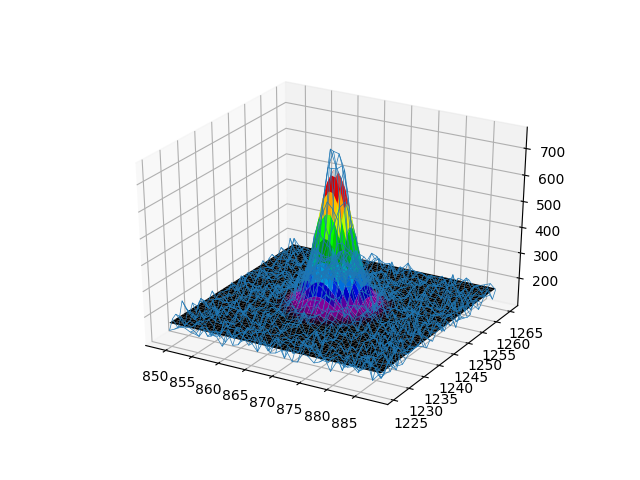

In [48]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

ax3d.plot_wireframe(X,Y,P,lw=0.5)

ngrid=50
Xs,Ys=np.meshgrid(np.linspace(xs[0],xs[-1],ngrid),np.linspace(ys[0],ys[-1],ngrid))
Zs=gaussianLevel2(Xs,Ys,
                  level=g.level.value,amplitude=g.amplitude.value,
                  meanx=g.meanx.value,meany=g.meany.value,
                  sigmax2=g.sigmax2.value,sigmay2=g.sigmay2.value)

ax3d.plot_surface(Xs,Ys,Zs,cmap='nipy_spectral')

## Show only coordinates

<IPython.core.display.Javascript object>


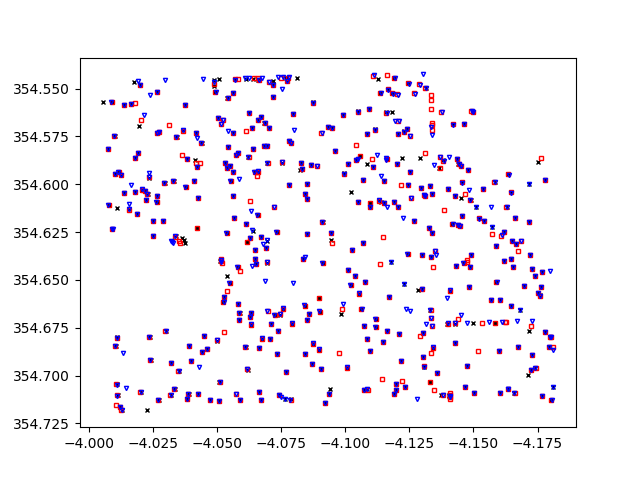

Range in RA: 354.542368063 354.718219255 0.175851191709
Range in DEC: -4.18199545289 -4.00539975212 0.176595700778


In [207]:
#READ OBJECTS
objs=[]
for i,image in enumerate(images):objs+=[rec2arr(image["objectsrd"])]
    
fig,axs=plt.subplots(1,1)

dmin=min([objs[i][:,1].min() for i in range(len(images))])
rmin=min([objs[i][:,0].min() for i in range(len(images))])
dmax=max([objs[i][:,1].max() for i in range(len(images))])
rmax=max([objs[i][:,0].max() for i in range(len(images))])

print("Range in RA:",rmin,rmax,rmax-rmin)
print("Range in DEC:",dmin,dmax,dmax-dmin)

axs.plot(objs[0][:,1],objs[0][:,0],'kx',ms=3)
axs.plot(objs[1][:,1],objs[1][:,0],'rs',ms=3,mfc='None')
axs.plot(objs[2][:,1],objs[2][:,0],'bv',ms=3,mfc='None')

axs.invert_xaxis()
axs.invert_yaxis()

In [50]:
#image["catalogue_header"]

<IPython.core.display.Javascript object>


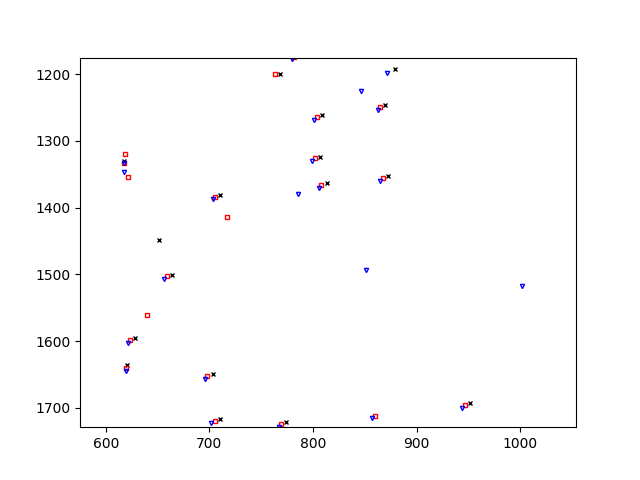

In [51]:
#READ OBJECTS
objs=[]
for i,image in enumerate(images):objs+=[rec2arr(image["catalogue"])]
    
fig,axs=plt.subplots(1,1)

axs.plot(objs[0][:,2],objs[0][:,4],'kx',ms=3)
axs.plot(objs[1][:,2],objs[1][:,4],'rs',ms=3,mfc='None')
axs.plot(objs[2][:,2],objs[2][:,4],'bv',ms=3,mfc='None')

#axs.invert_xaxis()
axs.invert_yaxis()

## Exploring FITS file

In [842]:
#See FITS file
image=images[0]
file=image["file"]
#hdul=fits.open(OUT_DIR+"%s-indx.xyls"%file)
#hdul=fits.open(OUT_DIR+"%s.rdls"%file)
#hdul=fits.open(OUT_DIR+"%s.wcs"%file)
hdul=fits.open(AST_DIR+"examples/tycho2-mag6.fits")
hdul[1].header
#hdul[1].data.shape

XTENSION= 'BINTABLE' / FITS Binary Table Extension                              
BITPIX  =                    8 / 8-bits character format                        
NAXIS   =                    2 / Tables are 2-D char. array                     
NAXIS1  =                   32 / Bytes in row                                   
NAXIS2  =                 4683 / no comment                                     
PCOUNT  =                    0 / Parameter count always 0                       
GCOUNT  =                    1 / Group count always 1                           
TFIELDS =                    6 / No. of col in table                            
TFORM1  = '1D      ' / Format of field                                          
TTYPE1  = 'RA      ' / Field label                                              
TUNIT1  = 'deg     ' / Physical unit of field                                   
TFORM2  = '1D      ' / Format of field                                          
TTYPE2  = 'DEC     ' / Field

In [845]:
#See FITS file
image=images[0]
file=image["file"]
#hdul=fits.open(OUT_DIR+"%s-indx.xyls"%file)
#hdul=fits.open(OUT_DIR+"%s.rdls"%file)
#hdul=fits.open(OUT_DIR+"%s.wcs"%file)
hdul=fits.open(AST_DIR+"data/astrometry-tycho2/build/index-4114.fits")
hdul[1].header
#hdul[1].data.shape

XTENSION= 'BINTABLE' / FITS Binary Table Extension                              
BITPIX  =                    8 / 8-bits character format                        
NAXIS   =                    2 / Tables are 2-D char. array                     
NAXIS1  =                   12 / Bytes in row                                   
NAXIS2  =                37632 / no comment                                     
PCOUNT  =                    0 / Parameter count always 0                       
GCOUNT  =                    1 / Group count always 1                           
TFIELDS =                    1 / No. of col in table                            
TFORM1  = '12A     ' / Format of field                                          
TTYPE1  = 'quads   ' / Field label                                              
ORIGIN  = 'ESO-QFITS' / Written by QFITS                                        
DATE    = '2017-12-31T23:38:00' / [UTC] Date of writing                         

## Tycho catalogue

In [55]:
tycho=pd.read_csv(DATA_DIR+"cat/tycho2.csv.gz")

In [71]:
#Get stars position
for i 
image=images[1]
ax=image["ax"]
stars=rec2arr(image["sources"])
#image["sources_header"]

XTENSION= 'BINTABLE' / FITS Binary Table Extension                              
BITPIX  =                    8 / 8-bits character format                        
NAXIS   =                    2 / Tables are 2-D char. array                     
NAXIS1  =                   16 / Bytes in row                                   
NAXIS2  =                   35 / no comment                                     
PCOUNT  =                    0 / Parameter count always 0                       
GCOUNT  =                    1 / Group count always 1                           
TFIELDS =                    2 / No. of col in table                            
TFORM1  = '1D      ' / Format of field                                          
TTYPE1  = 'RA      ' / Field label                                              
TUNIT1  = 'deg     ' / Physical unit of field                                   
TFORM2  = '1D      ' / Format of field                                          
TTYPE2  = 'DEC     ' / Field

<IPython.core.display.Javascript object>


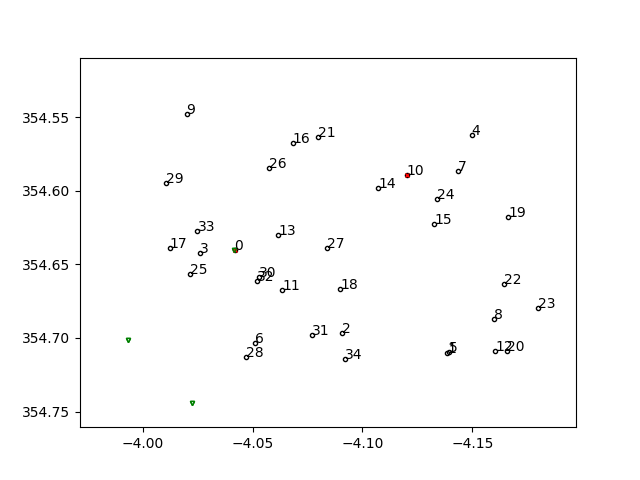

In [120]:
#Plot stars
fig,axs=plt.subplots(1,1)

for 
axs.plot(stars[:,1],stars[:,0],'ko',ms=3,mfc='None')
#for i in range(stars.shape[0]):
#    axs.text(stars[i,1],stars[i,0],'%d'%i,fontsize=10,color='k')
axs.invert_xaxis()
axs.invert_yaxis()

In [123]:
#Get one star
istar=0
star=stars[istar,:]
ra=star[0]
dec=star[1]
axs.plot([star[1]],[star[0]],'rx',ms=3)

In [124]:
ras=tycho.ra_tyc
decs=tycho.dec_tyc
s=((ra-tycho.ra_tyc)**2+(dec-tycho.dec_tyc)**2).sort_values()
print(s)
iclose=s.index[:100]
axs.plot(decs[iclose],ras[iclose],'gv',ms=3,mfc='None')

551651     1.529711e-08
551649     6.097291e-03
551639     1.122151e-02
551662     6.596758e-02
551658     7.287499e-02
551638     8.914153e-02
551655     1.194093e-01
551719     1.482926e-01
551699     1.503792e-01
551646     1.667558e-01
551656     1.832730e-01
551713     1.990709e-01
551710     3.031361e-01
551647     3.675845e-01
551642     3.939797e-01
551718     4.371171e-01
551643     4.746825e-01
551661     4.752229e-01
551695     6.138248e-01
551654     6.603850e-01
551653     6.815578e-01
551666     7.230965e-01
551640     7.618097e-01
551641     7.805585e-01
551648     7.936888e-01
551660     8.201146e-01
551619     8.541749e-01
551644     8.588163e-01
551659     8.809135e-01
551626     8.913428e-01
               ...     
499692     1.324929e+05
488718     1.324958e+05
488358     1.324997e+05
500407     1.325143e+05
488751     1.325454e+05
500482     1.325659e+05
499795     1.326252e+05
488340     1.326572e+05
500459     1.326595e+05
500443     1.326680e+05
499694     1.327

<IPython.core.display.Javascript object>


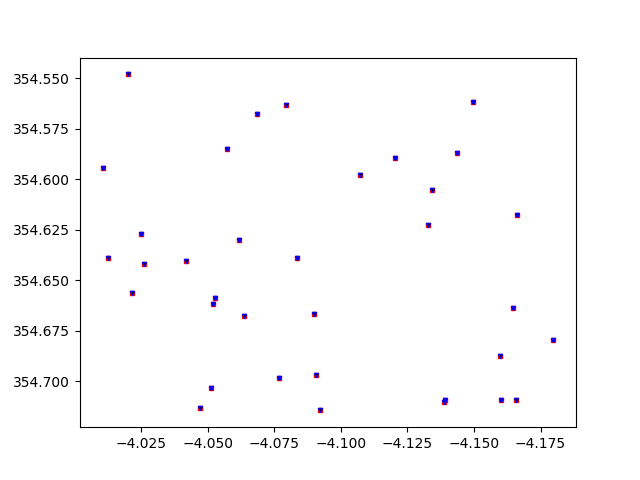

In [125]:
#READ OBJECTS
objs=[]
for i,image in enumerate(images):objs+=[rec2arr(image["sources"])]
    
fig,axs=plt.subplots(1,1)

dmin=min([objs[i][:,1].min() for i in range(len(images))])
rmin=min([objs[i][:,0].min() for i in range(len(images))])
dmax=max([objs[i][:,1].max() for i in range(len(images))])
rmax=max([objs[i][:,0].max() for i in range(len(images))])

axs.plot(objs[0][:,1],objs[0][:,0],'kx',ms=3)
axs.plot(objs[1][:,1],objs[1][:,0],'rs',ms=3,mfc='None')
axs.plot(objs[2][:,1],objs[2][:,0],'bv',ms=3,mfc='None')

axs.invert_xaxis()
axs.invert_yaxis()

## Filter objects that appear in the three images

In [286]:
#Build a complete list of objects
allobjs=pd.DataFrame()
for i,image in enumerate(images):
    rds=pd.DataFrame(image["objectsrd"])
    xys=pd.DataFrame(image["objects"])
    alls=pd.concat([rds,xys],axis=1)
    alls["IMG"]=i #In which image is the object
    alls["OBJ"]=0 #To which object it belongs
    alls["NIMG"]=1 #In how many images is the object present
    allobjs=allobjs.append(alls)
allobjs.sort_values(by="MAG_AUTO",inplace=True)
allobjs.reset_index(inplace=True)

print("Total number of objects:",len(allobjs))
print("Database fields:",allobjs.columns)
allobjs.head()

Total number of objects: 1619
Database fields: Index(['index', 'RA', 'DEC', 'X_IMAGE', 'Y_IMAGE', 'MAG_AUTO', 'FLUX_AUTO',
       'IMG', 'OBJ', 'NIMG'],
      dtype='object')


,index,RA,DEC,X_IMAGE,Y_IMAGE,MAG_AUTO,FLUX_AUTO,IMG,OBJ,NIMG
0,0,354.696825,-4.090717,1143.790771,2146.656494,-15.891790,2273611.250,0,0,1
1,0,354.696811,-4.090719,1138.649902,2149.378906,-15.874387,2237457.500,1,0,1
2,0,354.696800,-4.090640,1133.667603,2157.061523,-15.793650,2077112.000,3,0,1
3,0,354.696779,-4.090684,1136.432007,2153.359375,-15.782496,2055883.500,2,0,1
4,1,354.586739,-4.143470,1928.047485,627.905151,-15.357066,1389396.875,1,0,1


In [288]:
# Search radius
radius=3*pxsize
print("Search radius (deg):",radius)

verb=0
iobj=1
for i,ind in enumerate(allobjs.index):
    obj=allobjs.loc[ind]
    ra=obj.RA
    dec=obj.DEC
    if obj.NIMG>1:continue
        
    if verb:print("Object %d: %d"%(i,ind))
    if verb:print("\tPosition:",ra,dec)

    #COMPUTE THE EUCLIDEAN DISTANCE TO ALL OBJECTS NOT FOUND YET
    cond=allobjs.NIMG==1
    searchobjs=allobjs[cond]
    if verb:print("\tSearchable objects:",len(searchobjs))
    ds=((ra-searchobjs["RA"])**2+(dec-searchobjs["DEC"])**2).apply(np.sqrt)
    
    #IN HOW MANY IMAGES THE OBJECT IS PRESENT
    cond=ds<radius
    inds=searchobjs[cond].index
    nimg=len(allobjs.ix[inds])
    allobjs.loc[inds,"NIMG"]=nimg
    if verb:print("\tRepeated in %d images"%nimg)
    
    #ASSIGN OBJECT NUMBER
    if nimg==4:
        allobjs.loc[inds,"OBJ"]=iobj
        if verb:print("\t%d objects belong to single object %d"%(nimg,iobj))
        iobj+=1
    #if iobj>2:break
        
allobjs

Search radius (deg): 0.000212995462874


,index,RA,DEC,X_IMAGE,Y_IMAGE,MAG_AUTO,FLUX_AUTO,IMG,OBJ,NIMG
0,0,354.696825,-4.090717,1143.790771,2146.656494,-15.891790,2.273611e+06,0,1,4
1,0,354.696811,-4.090719,1138.649902,2149.378906,-15.874387,2.237458e+06,1,1,4
2,0,354.696800,-4.090640,1133.667603,2157.061523,-15.793650,2.077112e+06,3,1,4
3,0,354.696779,-4.090684,1136.432007,2153.359375,-15.782496,2.055884e+06,2,1,4
4,1,354.586739,-4.143470,1928.047485,627.905151,-15.357066,1.389397e+06,1,2,4
5,1,354.586640,-4.143512,1933.115112,625.279419,-15.319188,1.341761e+06,0,2,4
6,1,354.709878,-4.138454,1797.970215,2360.542236,-15.270443,1.282854e+06,3,0,1
7,1,354.586813,-4.143571,1925.804932,631.827087,-15.258545,1.268873e+06,2,2,4
8,2,354.586794,-4.143459,1923.151978,635.534058,-15.232236,1.238495e+06,3,2,4
9,9,354.561907,-4.149804,2022.434937,288.347961,-15.209644,1.212991e+06,3,0,2


<IPython.core.display.Javascript object>


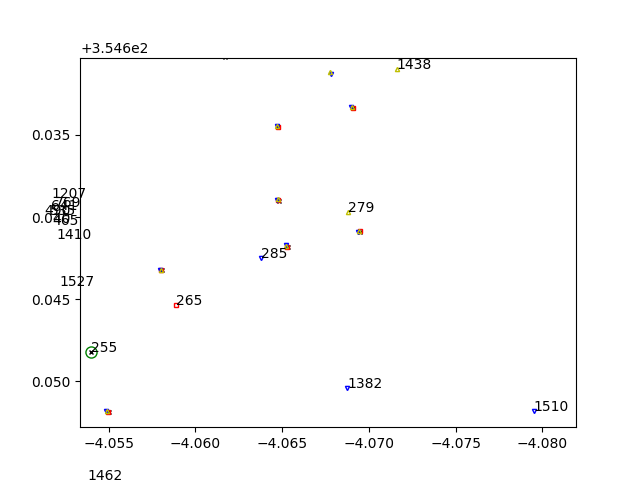

Range in RA: 354.542368063 354.718219255 0.175851191709
Range in DEC: -4.18199545289 -4.00539975212 0.176595700778
Number of potential moving objects: 284


In [456]:
#PLOT OBJECTS
objs=[]
for i,image in enumerate(images):objs+=[rec2arr(image["objectsrd"])]
    
fig,axs=plt.subplots(1,1)

dmin=min([objs[i][:,1].min() for i in range(len(images))])
rmin=min([objs[i][:,0].min() for i in range(len(images))])
dmax=max([objs[i][:,1].max() for i in range(len(images))])
rmax=max([objs[i][:,0].max() for i in range(len(images))])

print("Range in RA:",rmin,rmax,rmax-rmin)
print("Range in DEC:",dmin,dmax,dmax-dmin)

#Plot all objects
axs.plot(objs[0][:,1],objs[0][:,0],'kx',ms=3)
axs.plot(objs[1][:,1],objs[1][:,0],'rs',ms=3,mfc='None')
axs.plot(objs[2][:,1],objs[2][:,0],'bv',ms=3,mfc='None')
axs.plot(objs[3][:,1],objs[3][:,0],'y^',ms=3,mfc='None')

#Plot only the clusters
moving=allobjs[allobjs.NIMG<2]
print("Number of potential moving objects:",len(moving))
axs.plot(moving[moving.IMG==0].DEC,moving[moving.IMG==0].RA,'go',ms=8,mfc='None')

i=0
for dec,ra in zip(moving[moving.IMG>=0].DEC.values,moving[moving.IMG>=0].RA.values):
    text="%d"%moving[moving.IMG>=0].index[i]
    axs.text(dec,ra,text)
    i+=1

axs.invert_xaxis()
axs.invert_yaxis()

In [446]:
moving=allobjs[allobjs.NIMG<2]
imov=3
axs.plot(moving.iloc[imov].DEC,moving.iloc[imov].RA,'rs',ms=10,mfc='None')
moving.head()

,index,RA,DEC,X_IMAGE,Y_IMAGE,MAG_AUTO,FLUX_AUTO,IMG,OBJ,NIMG
6,1,354.709878,-4.138454,1797.970215,2360.542236,-15.270443,1.282854e+06,3,0,1
10,10,354.710548,-4.138171,1793.677368,2369.815674,-15.173492,1.173268e+06,3,0,1
11,18,354.710188,-4.138556,1799.252930,2364.930420,-14.959467,9.633556e+05,3,0,1
25,18,354.562000,-4.150005,2025.313965,285.684204,-14.238272,4.958024e+05,2,0,1
31,36,354.709012,-4.165778,2181.840332,2359.764404,-13.871622,3.537113e+05,3,0,1


In [455]:
moving[moving.IMG==0].loc[255]

index           66.000000
RA             354.648200
DEC             -4.054003
X_IMAGE        651.178284
Y_IMAGE       1448.391357
MAG_AUTO       -10.074632
FLUX_AUTO    10711.561523
IMG              0.000000
OBJ              0.000000
NIMG             1.000000
Name: 255, dtype: float64

In [409]:
#Select all moving objects in the first image
layers=[]
times=[]
nlayers=[]
for i in range(4):
    layers+=[moving[moving.IMG==i].sort_values(by=['RA','DEC'])]
    nlayers+=[len(layers[-1])]
    times+=[date2unix(images[i]["obstime"])]
times=np.array(times)
print("Number of stars in layers:",nlayers)
print("Times between images:",times[1:]-times[:-1])
#ilay=0
#axs.plot(layer0.iloc[ilay].DEC,layer0.iloc[ilay].RA,'rs',ms=10,mfc='None')


Number of stars in layers: [66, 70, 66, 82]
Times between images: [ 1035.34286785  1031.73969817  1029.70840383]


<IPython.core.display.Javascript object>


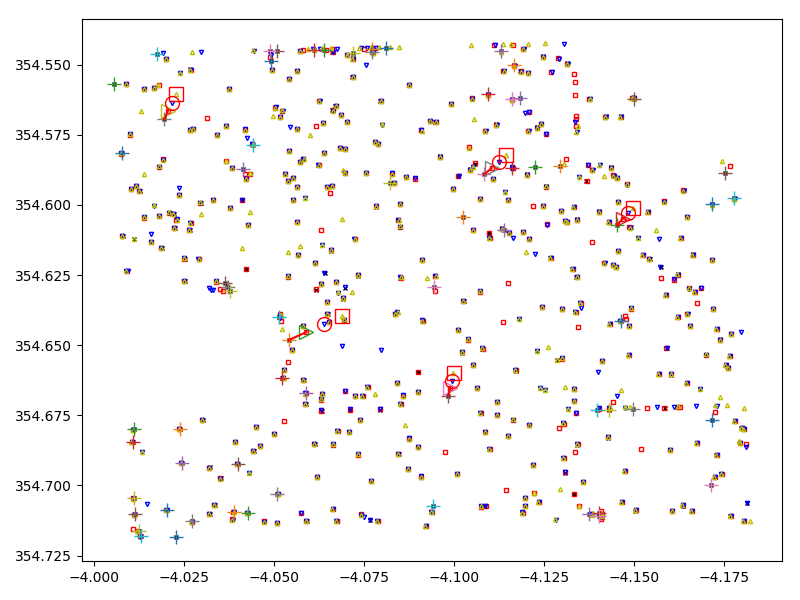

Range in RA: 354.542368063 354.718219255 0.175851191709
Range in DEC: -4.18199545289 -4.00539975212 0.176595700778


In [608]:
#PLOT OBJECTS
objs=[]
for i,image in enumerate(images):objs+=[rec2arr(image["objectsrd"])]
    
#fig,axs=plt.subplots(5,1,sharex=True,sharey=True,figsize=(8,12))
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(8,6))

dmin=min([objs[i][:,1].min() for i in range(len(images))])
rmin=min([objs[i][:,0].min() for i in range(len(images))])
dmax=max([objs[i][:,1].max() for i in range(len(images))])
rmax=max([objs[i][:,0].max() for i in range(len(images))])

print("Range in RA:",rmin,rmax,rmax-rmin)
print("Range in DEC:",dmin,dmax,dmax-dmin)

#Plot all objects
#axs[1].plot(objs[0][:,1],objs[0][:,0],'kx',ms=3)
#axs[2].plot(objs[1][:,1],objs[1][:,0],'rs',ms=3,mfc='None')
#axs[3].plot(objs[2][:,1],objs[2][:,0],'bv',ms=3,mfc='None')
#axs[4].plot(objs[3][:,1],objs[3][:,0],'y^',ms=3,mfc='None')

axs.plot(objs[0][:,1],objs[0][:,0],'kx',ms=3)
axs.plot(objs[1][:,1],objs[1][:,0],'rs',ms=3,mfc='None')
axs.plot(objs[2][:,1],objs[2][:,0],'bv',ms=3,mfc='None')
axs.plot(objs[3][:,1],objs[3][:,0],'y^',ms=3,mfc='None')

axs.invert_xaxis()
axs.invert_yaxis()
fig.tight_layout()

## Moving algorithm implementation

In [609]:
verb=0

#Ranges
ramax=max(allobjs.RA);ramin=min(allobjs.RA)
decmax=max(allobjs.DEC);decmin=min(allobjs.DEC)
print("Range RA:",ramin,ramax)
print("Range DEC:",decmin,decmax)

#First level of crossing
#Time between layers
dt1=(times[1]-times[0])/HOUR
dt2=(times[2]-times[1])/HOUR
dt3=(times[3]-times[1])/HOUR
print("Time between layers (seconds):",dt)
#ax=axs[0]
ax=axs

nobj=0
indxs=[]
for indl in layers[0].index:
    #if indl!=255:continue
    #Get object in Layer 0
    objl=layers[0].loc[indl]
    ax.plot(objl.DEC,objl.RA,'+',ms=10)
    if verb:print("Testing object %d"%indl)
    nout=0
    nfar=0
    nfou=0
    ntot=0
    for indu in layers[1].index:
        #if indu!=265:continue
        #Get object in Layer 1
        ntot+=1
        obju=layers[1].loc[indu]
        
        #Compute speed
        vr=(obju.RA-objl.RA)/dt1
        vd=(obju.DEC-objl.DEC)/dt1
        if verb:print("Speed (muRA,muDEC) (deg/h):",vr,vd)

        #Check distance
        d=np.sqrt((vr*dt1)**2+(vd*dt1)**2)
        if d<2*radius:continue
        
        ##########################################################################################
        ##########################################################################################
        #Extrapolate to next layer (Layer 2)
        ran=obju.RA+vr*dt2
        decn=obju.DEC+vd*dt2

        #Check if extrapolated position is beyond searching region
        if ran>ramax or ran<ramin or decn>decmax or decn<decmin:
            if verb:print("Out of image")
            nout+=1
            continue
        
        #Search for close objects in the next layer (Layer 2)
        cond=((layers[2].DEC-decn)**2+(layers[2].RA-ran)**2).apply(np.sqrt).sort_values()<radius
        exts=layers[2][cond]
        if len(exts)==0:
            if verb:print("Not close objects")
            nfar+=1
            continue

        dmin=((exts.DEC-decn)**2+(exts.RA-ran)**2).apply(np.sqrt).iat[0]
        idmin1=exts.index[0]

        if dmin<radius:
            if verb:print("\tFound next layer %d"%idmin1)
            #ax.plot(obju.DEC,obju.RA,'>',ms=10,mfc='None')
            #ax.plot([objl.DEC,obju.DEC],[objl.RA,obju.RA],'r-')
            #ax.plot(decn,ran,'ro',ms=10,mfc='None')
        ##########################################################################################
        ##########################################################################################

        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        #Extrapolate to next layer (Layer 3)
        rau=obju.RA+vr*dt3
        decu=obju.DEC+vd*dt3

        #Check if extrapolated position is beyond searching region
        if rau>ramax or rau<ramin or decu>decmax or decu<decmin:
            if verb:print("Out of image")
            nout+=1
            continue
            
        #Search for close objects in the next layer (Layer 3)
        cond=((layers[3].DEC-decu)**2+(layers[3].RA-rau)**2).apply(np.sqrt).sort_values()<radius
        exts=layers[3][cond]
        if len(exts)==0:
            if verb:print("Not close objects")
            nfar+=1
            continue
        
        dmin=((exts.DEC-decu)**2+(exts.RA-rau)**2).apply(np.sqrt).iat[0]
        idmin2=exts.index[0]

        if dmin<radius:
            if verb:print("\tFound final layer %d"%idmin2)
            nfou+=1
            nobj+=1
            ax.plot(obju.DEC,obju.RA,'>',ms=10,mfc='None')
            ax.plot([objl.DEC,obju.DEC],[objl.RA,obju.RA],'r-')
            ax.plot(decn,ran,'ro',ms=10,mfc='None')
            ax.plot(decu,rau,'rs',ms=10,mfc='None')
            
            indxs+=[indl,indu,idmin1,idmin2]

        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    if verb:print("Statistics: tot=%d,out=%d,far=%d,found=%d"%(ntot,nout,nfar,nfou))
    #break
print("%d objects found"%nobj)
print("Objects:",indxs)
print("Done.")

Range RA: 354.5423680632783 354.7182192549872
Range DEC: -4.181995452893534 -4.005399752115534
Time between layers (seconds): 0.28759524107
5 objects found
Objects: [1078, 1153, 1201, 1001, 851, 692, 916, 899, 853, 945, 947, 1002, 255, 265, 285, 279, 984, 1054, 1106, 1074]
Done.


## Animated gif

<IPython.core.display.Javascript object>


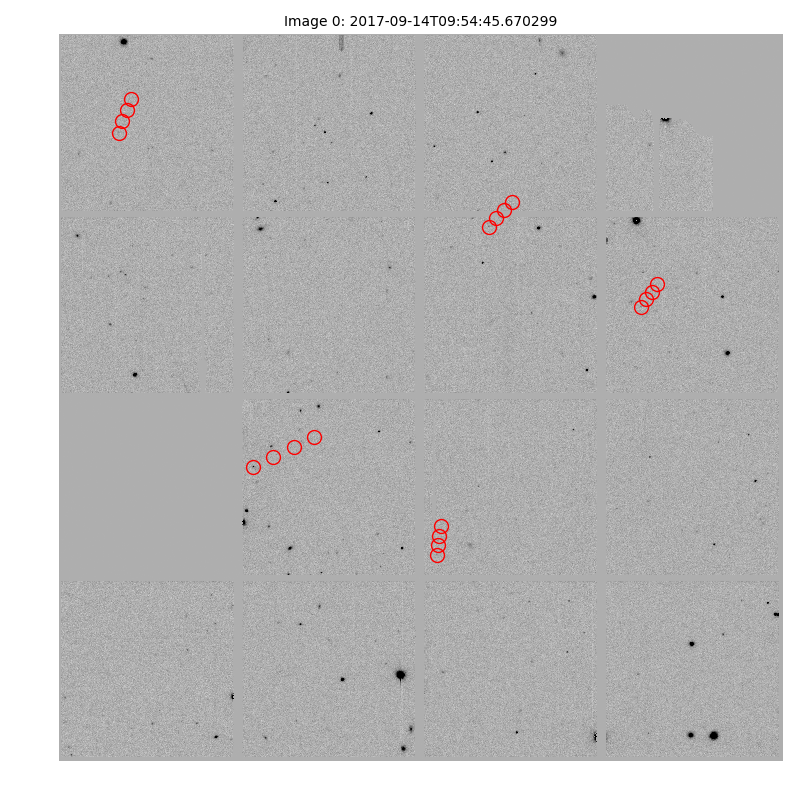

In [619]:
import matplotlib.animation as animation
fig=plt.figure(figsize=(8,8))

imgargs=dict(cmap='gray_r',vmin=0,vmax=500)
im=plt.imshow(images[0]["data"],animated=True,**imgargs)
tm=plt.title("Image 0: "+images[0]["obstime"],fontsize=10)

for ind in indxs:
    obj=allobjs.loc[ind]
    plt.plot(obj.X_IMAGE,obj.Y_IMAGE,'ro',ms=10,mfc='None')
    #break

plt.axis("off")
fig.tight_layout()

def updatefig(i):
    iimg=i%4
    im.set_array(images[iimg]["data"])
    tm.set_text("Image %d: "%iimg+images[i%4]["obstime"])
    return im,

ani=animation.FuncAnimation(fig,updatefig,frames=[0,1,2,3],interval=500,repeat_delay=1000,repeat=True)
#ani.save(OUT_DIR+'blink.html')

## Useful routines and Macros

In [438]:
#MACROS
DEG=np.pi/180
RAD=1/DEG
ARCSEC=1./3600
ARCMIN=60*ARCSEC
MINUTE=60.0
HOUR=60*MINUTE
DAY=24*HOUR

#Get configuration line from a list  
#Example: Config(cfg,"Latitude")
Config=lambda c,x:[s for s in c if x in s]
def Config(c,x):
    vs=[]
    for t in [s for s in c if x in s]:
        vs+=[t.split("=")[1]]
    if len(vs)==1:
        try:vs=float(vs[0])
        except:vs=vs[0]
    return vs

#Convert from sexagesimal to decimal
#Example: sex2dec("23 03 45")
sex2dec=lambda s:np.sign(float(s.split()[0]))*(np.array([np.abs(float(x)) for x in s.split()]).dot([1.0,1/60.0,1/3600.]).sum())

def dec2sex(d):
    s=np.sign(d)
    d=np.abs(d)
    dg=int(d)
    mm=(d-dg)*60
    mg=int(mm)
    sg=(mm-mg)*60
    return s*dg,mg,sg


#Convert a matrix of axes into a list
mat2lst=lambda M:M.reshape(1,sum(M.shape))[0].tolist()

#Intelligent Shell script execution
def _run(cmd):
    import sys,subprocess
    p=subprocess.Popen(cmd,stdout=subprocess.PIPE,stderr=subprocess.PIPE,shell=True)
    while True:
        line = p.stdout.readline().rstrip()
        if not line:
            break
        yield line
    (output,error)=p.communicate()
    yield p.returncode,error

def System(cmd,verbose=True):
    out=[]
    for path in _run(cmd):
        try:
            if verbose:print(path.decode("utf-8"))
            out+=[path.decode("utf-8")]
        except:
            out+=[(path[0],path[1].decode("utf-8"))]
            pass
    return out

#Convert a record array (mixed type) in a double arrays
#Example: a = np.recarray((1,), dtype=[('x', int), ('y', float), ('z', int)]); 
#a['x']=1;a['y']=2.3;a['z']=4
#a=rec2arr(a)
def rec2arr(a):
    a=np.array(a)
    dt = a.dtype
    dt = dt.descr
    nt=[]
    for t in dt:
        t = (t[0], 'float64')
        nt+=[t]
    dt = np.dtype(nt)
    a = a.astype(dt)
    a=a.view(np.float).reshape(a.shape + (-1,))
    return a

def date2unix(datet):
    #datet="2017-09-14T09:54:45.670299"
    sec=float(datet.split(":")[-1])
    import time,ciso8601
    ts=ciso8601.parse_datetime(datet)
    unix=time.mktime(ts.timetuple())+(sec-int(sec))
    return unix
    